# Apprentissage Supervisé : Credit Approval

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

In [4]:
import numpy as np 

import pandas as pd 
import warnings 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
import time

from sklearn.metrics import accuracy_score, precision_score

from sklearn.model_selection import KFold,cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [ ]:
np.set_printoptions(threshold=np.nan,suppress=True)

### I. Apprentissage supervisé : Feature engineering et Classification 

Taille échantillons:  (4375, 13)


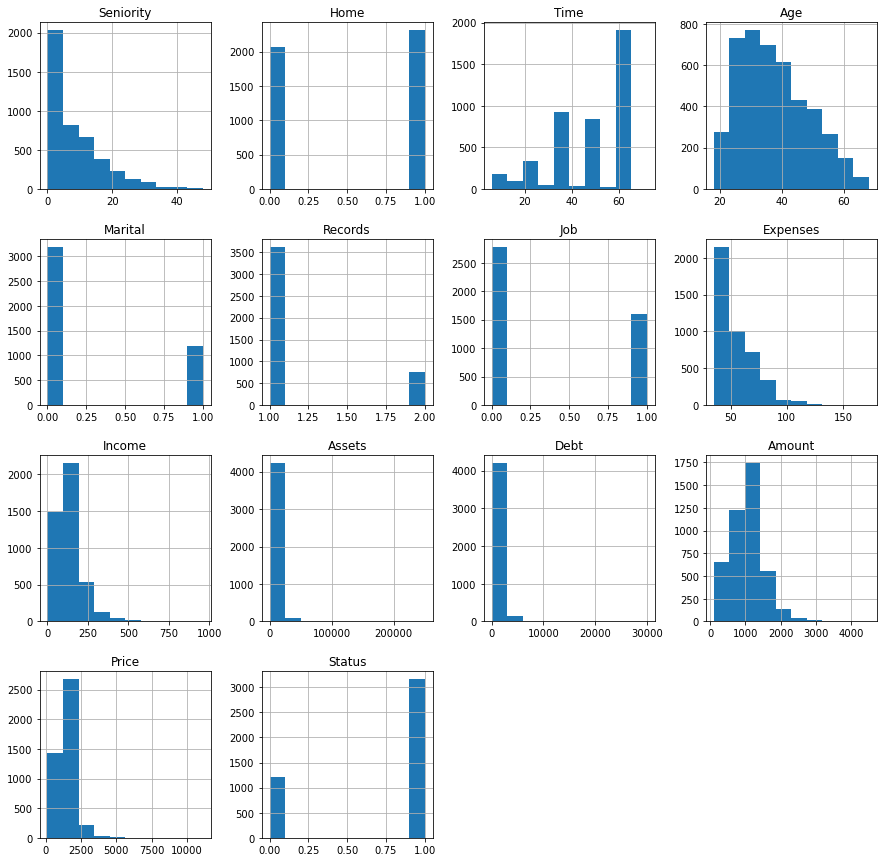

In [5]:
df = pd.read_csv('./credit_scoring.csv', sep=';')
data=df.values

Y=data[:,13]
X=data[:,0:13]

print('Taille échantillons: ',np.shape(X))

hist=df.hist(figsize=(15,15))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.5, random_state=0)

### Evaluation de Modèle


In [7]:
def score(Y_train,Y_test,X_train,X_test):
    CART = DecisionTreeClassifier(random_state=1)
    CART.fit(X_train,Y_train)
    neigh = KNeighborsClassifier(n_neighbors=5)
    KNN=neigh.fit(X_train, Y_train)
    print("Cart accuracy:",accuracy_score(Y_test , CART.predict(X_test)))
    print("Cart precision:",precision_score(Y_test , CART.predict(X_test)))
    print("KNN accuracy:",accuracy_score(Y_test, KNN.predict(X_test)))
    print("KNN precision:",precision_score(Y_test, KNN.predict(X_test)))

score(Y_train,Y_test,X_train,X_test)   
    

Cart accuracy: 0.7248628884826326
Cart precision: 0.8174247277386291
KNN accuracy: 0.7138939670932358
KNN precision: 0.769659788064696


#### NORMALISER LES DONNEES

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X2_train = scaler.transform(X_train)
X2_test = scaler.transform(X_test)

In [9]:
scaler2 = MinMaxScaler()

scaler2.fit(X_train)
X4_train = scaler2.transform(X_train)
X4_test = scaler2.transform(X_test)

#### EVALUATION DONNEES NORMALISE

In [10]:
score(Y_train,Y_test,X2_train,X2_test)  

Cart accuracy: 0.7239488117001828
Cart precision: 0.8163787587971849
KNN accuracy: 0.7490859232175503
KNN precision: 0.8148371531966224


### ACP

In [11]:
pca = PCA(n_components=3)
pca.fit(X2_train)
print(pca.explained_variance_ratio_) 
X3_train = pca.transform(X2_train)
X3_test = pca.transform(X2_test)
X3_train=np.concatenate((X2_train,X3_train),axis=1)
X3_test=np.concatenate((X2_test,X3_test),axis=1)

[0.19246071 0.14757952 0.10162894]


In [12]:
score(Y_train,Y_test,X3_train,X3_test) 

Cart accuracy: 0.7422303473491774
Cart precision: 0.8338741077222582
KNN accuracy: 0.7600548446069469
KNN precision: 0.8174791914387634


### Selection de Variables

['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Records' 'Expenses'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


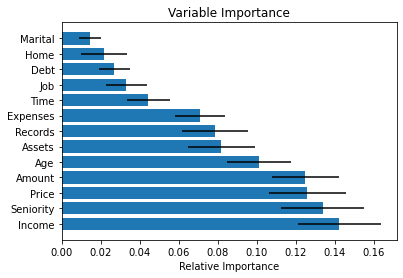

In [13]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X2_train,Y_train) 
importances=clf.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0) 
 
sorted_idx = np.argsort(importances)[::-1] 
 
features =df.columns.values
print(features[sorted_idx]) 
 
padding = np.arange(X2_train.size/len(X2_train)) + 0.5  
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')  
plt.yticks(padding, features[sorted_idx])  
plt.xlabel("Relative Importance") 
plt.title("Variable Importance")  
plt.show() 

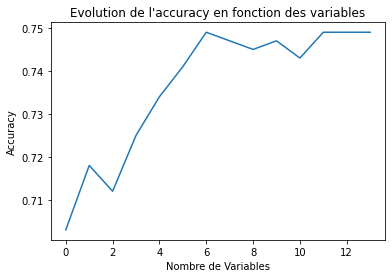

In [14]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(X2_train.shape[1]+1)
for f in np.arange(0, X2_train.shape[1]+1):
    X1_f = X2_train[:,sorted_idx[:f+1]]
    X2_f = X2_test[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,Y_train)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(Y_test,YKNN),3) 

plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

### Paramétrage des classifieurs

In [15]:
parameters_cart = {'criterion':["gini","entropy"],"max_depth":[1,2,3,4,5,6,7,8]}
CART = DecisionTreeClassifier(random_state=1)
cartp= GridSearchCV(CART, parameters_cart, cv=10)
print("CART param:" ,cartp.fit(X2_train, Y_train).best_params_)

parameters_knn = {'n_neighbors':[5,10,15,20]}
KNN = KNeighborsClassifier(n_neighbors=5)
knnp= GridSearchCV(KNN, parameters_knn, cv=10)
print("KNN param:" ,knnp.fit(X2_train, Y_train).best_params_)

CART param: {'criterion': 'entropy', 'max_depth': 6}
KNN param: {'n_neighbors': 15}


### Création d’un pipeline

In [16]:
Pipe_cart=Pipeline([('Normalisation',StandardScaler()),
                    ('FU',FeatureUnion([('Normalisation',StandardScaler()),
                                                                           ('pca',PCA(n_components=3))])),
                    ('cart',DecisionTreeClassifier(random_state=1))])
Pipe_cart.fit(X_train,Y_train)
print("Cart accuracy:",accuracy_score(Y_test , Pipe_cart.predict(X_test)))
print("Cart precision:",precision_score(Y_test , Pipe_cart.predict(X_test)))

Pipe_knn=Pipeline([('Normalisation',StandardScaler()),
                   ('FU',FeatureUnion([('Normalisation',StandardScaler()),
                                       ('pca',PCA(n_components=3))])),
                   ('knn',KNeighborsClassifier(n_neighbors=5))])
Pipe_knn.fit(X_train,Y_train)
print("Knn accuracy:",accuracy_score(Y_test , Pipe_knn.predict(X_test)))
print("Knn precision:",precision_score(Y_test , Pipe_knn.predict(X_test)))


Cart accuracy: 0.7422303473491774
Cart precision: 0.8338741077222582
Knn accuracy: 0.7600548446069469
Knn precision: 0.8174791914387634


### Comparaison d'algos

In [17]:
clfs = {
 'RF': RandomForestClassifier(n_estimators=50),
 'KNN': KNeighborsClassifier(n_neighbors=5), 
 'NB' : GaussianNB(),
 'CART': DecisionTreeClassifier(random_state=1),
 'MLP': MLPClassifier(alpha=1),
 'AB': AdaBoostClassifier(n_estimators=50),
 'BG': BaggingClassifier(n_estimators=50),
 'ID3': DecisionTreeClassifier(random_state=1,criterion="entropy"),
 'SP': DecisionTreeClassifier(random_state=1,max_depth=1)
}

def run_classifiers(clfs,X,Y):
    kf10 = KFold(n_splits=10, shuffle=True, random_state=0)
    kf5 = KFold(n_splits=5, shuffle=True, random_state=0)
    for i in clfs:
        clf = clfs[i]
        t=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf10)
        cv_auc = cross_val_score(clf, X, Y, cv=kf10, scoring='roc_auc')
        cv_rec = cross_val_score(clf, X, Y, cv=kf5, scoring='recall')
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_acc), np.std(cv_acc)))
        print("AUC for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_auc), np.std(cv_auc)))
        print("Recall for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_rec), np.std(cv_rec)))
        print("Time for {0} is: {1:.2f}".format(i,time.time()-t))
        print()
run_classifiers(clfs,X,Y)

Accuracy for RF is: 0.785 +/- 0.013
AUC for RF is: 0.825 +/- 0.020
Recall for RF is: 0.893 +/- 0.010
Time for RF is: 4.25

Accuracy for KNN is: 0.715 +/- 0.017
AUC for KNN is: 0.662 +/- 0.027
Recall for KNN is: 0.869 +/- 0.015
Time for KNN is: 0.51

Accuracy for NB is: 0.772 +/- 0.022
AUC for NB is: 0.791 +/- 0.026
Recall for NB is: 0.859 +/- 0.008
Time for NB is: 0.05

Accuracy for CART is: 0.727 +/- 0.025
AUC for CART is: 0.656 +/- 0.032
Recall for CART is: 0.806 +/- 0.011
Time for CART is: 0.38

Accuracy for MLP is: 0.707 +/- 0.057
AUC for MLP is: 0.743 +/- 0.025
Recall for MLP is: 0.873 +/- 0.119
Time for MLP is: 7.92

Accuracy for AB is: 0.788 +/- 0.016
AUC for AB is: 0.829 +/- 0.021
Recall for AB is: 0.905 +/- 0.012
Time for AB is: 3.31

Accuracy for BG is: 0.776 +/- 0.013
AUC for BG is: 0.817 +/- 0.018
Recall for BG is: 0.874 +/- 0.015
Time for BG is: 11.90

Accuracy for ID3 is: 0.723 +/- 0.024
AUC for ID3 is: 0.664 +/- 0.029
Recall for ID3 is: 0.803 +/- 0.013
Time for ID3 is: 0

L'algorithmes le plus efficace est Ada Boost suivie de pret par Random Forest. 

### II. Apprentissage supervisé : Données hétérogènes

In [18]:
df = pd.read_csv('./credit.data',sep='\t')
df[df=='?']=np.nan
df=df.dropna()

credit=df.values
credit[credit=='?']=np.nan
Y=credit[:,-1]
X=credit[:,:15]
X_num=credit[:,[1,2,7,10,13,14]]
X_num=X_num.astype(float)
np.shape(df)

Y[Y=='+']=1
Y[Y=='-']=0
Y=Y.astype(float)

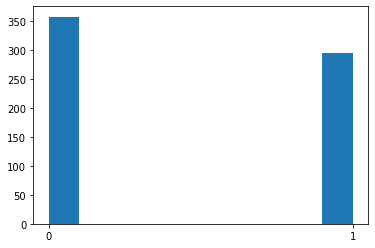

In [19]:
plt.hist([Y])
plt.xticks([0,1])
plt.show()

In [20]:
run_classifiers(clfs,X_num,Y)

Accuracy for RF is: 0.788 +/- 0.039
AUC for RF is: 0.849 +/- 0.052
Recall for RF is: 0.691 +/- 0.073
Time for RF is: 1.43

Accuracy for KNN is: 0.681 +/- 0.037
AUC for KNN is: 0.739 +/- 0.054
Recall for KNN is: 0.534 +/- 0.037
Time for KNN is: 0.07

Accuracy for NB is: 0.718 +/- 0.033
AUC for NB is: 0.799 +/- 0.014
Recall for NB is: 0.476 +/- 0.042
Time for NB is: 0.03

Accuracy for CART is: 0.713 +/- 0.068
AUC for CART is: 0.717 +/- 0.067
Recall for CART is: 0.694 +/- 0.062
Time for CART is: 0.06

Accuracy for MLP is: 0.742 +/- 0.059
AUC for MLP is: 0.770 +/- 0.064
Recall for MLP is: 0.637 +/- 0.102
Time for MLP is: 2.42

Accuracy for AB is: 0.771 +/- 0.043
AUC for AB is: 0.831 +/- 0.048
Recall for AB is: 0.728 +/- 0.067
Time for AB is: 1.34

Accuracy for BG is: 0.770 +/- 0.040
AUC for BG is: 0.834 +/- 0.051
Recall for BG is: 0.703 +/- 0.082
Time for BG is: 2.03

Accuracy for ID3 is: 0.722 +/- 0.042
AUC for ID3 is: 0.721 +/- 0.038
Recall for ID3 is: 0.692 +/- 0.053
Time for ID3 is: 0.

Le meilleur classifieur selon l'AUC est random forest.

In [21]:
scaler = StandardScaler()
X_norm=scaler.fit_transform(X_num)
run_classifiers(clfs,X_norm,Y)

Accuracy for RF is: 0.772 +/- 0.056
AUC for RF is: 0.852 +/- 0.046
Recall for RF is: 0.697 +/- 0.092
Time for RF is: 1.42

Accuracy for KNN is: 0.744 +/- 0.072
AUC for KNN is: 0.802 +/- 0.074
Recall for KNN is: 0.606 +/- 0.075
Time for KNN is: 0.08

Accuracy for NB is: 0.718 +/- 0.033
AUC for NB is: 0.799 +/- 0.014
Recall for NB is: 0.476 +/- 0.042
Time for NB is: 0.03

Accuracy for CART is: 0.712 +/- 0.069
AUC for CART is: 0.715 +/- 0.068
Recall for CART is: 0.694 +/- 0.062
Time for CART is: 0.07

Accuracy for MLP is: 0.778 +/- 0.059
AUC for MLP is: 0.843 +/- 0.039
Recall for MLP is: 0.657 +/- 0.064
Time for MLP is: 8.10

Accuracy for AB is: 0.771 +/- 0.043
AUC for AB is: 0.831 +/- 0.048
Recall for AB is: 0.728 +/- 0.067
Time for AB is: 1.36

Accuracy for BG is: 0.762 +/- 0.040
AUC for BG is: 0.834 +/- 0.049
Recall for BG is: 0.693 +/- 0.083
Time for BG is: 2.05

Accuracy for ID3 is: 0.725 +/- 0.039
AUC for ID3 is: 0.724 +/- 0.036
Recall for ID3 is: 0.692 +/- 0.053
Time for ID3 is: 0.

In [23]:
col_cat=[0,3,4,5,6,8,9,11,12]
X_cat = np.copy(X[:, col_cat])
for col_id in range(len(col_cat)):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
    X_cat[:, col_id] = val_idx
imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent')
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])

col_num=[1,2,7,10,13,14]
X_num = np.copy(X[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)

In [24]:
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()
X2=np.concatenate((X_cat_bin,X_norm),axis=1)
run_classifiers(clfs,X2,Y)

Accuracy for RF is: 0.876 +/- 0.031
AUC for RF is: 0.933 +/- 0.027
Recall for RF is: 0.865 +/- 0.054
Time for RF is: 1.30

Accuracy for KNN is: 0.845 +/- 0.039
AUC for KNN is: 0.898 +/- 0.034
Recall for KNN is: 0.799 +/- 0.031
Time for KNN is: 0.07

Accuracy for NB is: 0.733 +/- 0.080
AUC for NB is: 0.889 +/- 0.034
Recall for NB is: 0.443 +/- 0.087
Time for NB is: 0.04

Accuracy for CART is: 0.831 +/- 0.054
AUC for CART is: 0.834 +/- 0.054
Recall for CART is: 0.762 +/- 0.031
Time for CART is: 0.08

Accuracy for MLP is: 0.862 +/- 0.036
AUC for MLP is: 0.935 +/- 0.027
Recall for MLP is: 0.876 +/- 0.048
Time for MLP is: 9.00

Accuracy for AB is: 0.854 +/- 0.032
AUC for AB is: 0.923 +/- 0.034
Recall for AB is: 0.841 +/- 0.072
Time for AB is: 1.53

Accuracy for BG is: 0.862 +/- 0.048
AUC for BG is: 0.933 +/- 0.031
Recall for BG is: 0.862 +/- 0.022
Time for BG is: 2.40

Accuracy for ID3 is: 0.810 +/- 0.043
AUC for ID3 is: 0.808 +/- 0.040
Recall for ID3 is: 0.782 +/- 0.024
Time for ID3 is: 0.

### III. Apprentissage supervisé sur des données textuelles : Feature engineering et Classification

In [25]:
df = pd.read_csv('./SMSSpamCollection.data',sep='\t')
data=df.values
text=data[:,1]
Y=data[:,0]

In [26]:
vectorizer = CountVectorizer(min_df=0.08,max_df=0.85)
X_count=vectorizer.fit_transform(text).toarray()
Y[Y=="spam"]=0
Y[Y=="ham"]=1
Y=Y.astype(float)
run_classifiers(clfs,X_count,Y)

Accuracy for RF is: 0.929 +/- 0.007
AUC for RF is: 0.911 +/- 0.031
Recall for RF is: 0.974 +/- 0.008
Time for RF is: 2.99

Accuracy for KNN is: 0.921 +/- 0.011
AUC for KNN is: 0.878 +/- 0.030
Recall for KNN is: 0.972 +/- 0.009
Time for KNN is: 1.74

Accuracy for NB is: 0.839 +/- 0.017
AUC for NB is: 0.866 +/- 0.020
Recall for NB is: 0.849 +/- 0.012
Time for NB is: 0.10

Accuracy for CART is: 0.914 +/- 0.005
AUC for CART is: 0.843 +/- 0.036
Recall for CART is: 0.952 +/- 0.012
Time for CART is: 0.19

Accuracy for MLP is: 0.919 +/- 0.010
AUC for MLP is: 0.911 +/- 0.023
Recall for MLP is: 0.981 +/- 0.004
Time for MLP is: 24.92

Accuracy for AB is: 0.917 +/- 0.010
AUC for AB is: 0.904 +/- 0.026
Recall for AB is: 0.977 +/- 0.005
Time for AB is: 2.72

Accuracy for BG is: 0.923 +/- 0.009
AUC for BG is: 0.904 +/- 0.035
Recall for BG is: 0.966 +/- 0.007
Time for BG is: 5.79

Accuracy for ID3 is: 0.912 +/- 0.007
AUC for ID3 is: 0.840 +/- 0.032
Recall for ID3 is: 0.953 +/- 0.013
Time for ID3 is: 0

Random Forest predit plutot bien es spam ou ham avec CountVectorizer

In [27]:
transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = transformer.fit_transform(X_count).toarray()
run_classifiers(clfs,X_tfidf,Y)

Accuracy for RF is: 0.927 +/- 0.006
AUC for RF is: 0.914 +/- 0.033
Recall for RF is: 0.974 +/- 0.008
Time for RF is: 3.94

Accuracy for KNN is: 0.924 +/- 0.010
AUC for KNN is: 0.871 +/- 0.019
Recall for KNN is: 0.971 +/- 0.009
Time for KNN is: 1.76

Accuracy for NB is: 0.779 +/- 0.018
AUC for NB is: 0.827 +/- 0.014
Recall for NB is: 0.778 +/- 0.016
Time for NB is: 0.08

Accuracy for CART is: 0.917 +/- 0.007
AUC for CART is: 0.842 +/- 0.037
Recall for CART is: 0.956 +/- 0.007
Time for CART is: 0.35

Accuracy for MLP is: 0.897 +/- 0.012
AUC for MLP is: 0.901 +/- 0.022
Recall for MLP is: 0.983 +/- 0.004
Time for MLP is: 18.57

Accuracy for AB is: 0.917 +/- 0.009
AUC for AB is: 0.905 +/- 0.024
Recall for AB is: 0.976 +/- 0.006
Time for AB is: 3.43

Accuracy for BG is: 0.925 +/- 0.008
AUC for BG is: 0.907 +/- 0.037
Recall for BG is: 0.972 +/- 0.008
Time for BG is: 10.88

Accuracy for ID3 is: 0.918 +/- 0.008
AUC for ID3 is: 0.848 +/- 0.037
Recall for ID3 is: 0.956 +/- 0.009
Time for ID3 is: 

Amelioration notament pour Naive Bayes et CART

In [28]:
svd = TruncatedSVD(n_components=3)
X_svd=svd.fit_transform(X_tfidf)
X_svd_tfidf=np.concatenate((X_tfidf,X_svd),axis=1)
run_classifiers(clfs,X_svd_tfidf,Y)

Accuracy for RF is: 0.929 +/- 0.007
AUC for RF is: 0.913 +/- 0.036
Recall for RF is: 0.976 +/- 0.007
Time for RF is: 4.54

Accuracy for KNN is: 0.923 +/- 0.010
AUC for KNN is: 0.876 +/- 0.023
Recall for KNN is: 0.968 +/- 0.010
Time for KNN is: 1.85

Accuracy for NB is: 0.780 +/- 0.014
AUC for NB is: 0.843 +/- 0.014
Recall for NB is: 0.772 +/- 0.016
Time for NB is: 0.10

Accuracy for CART is: 0.918 +/- 0.007
AUC for CART is: 0.841 +/- 0.046
Recall for CART is: 0.954 +/- 0.010
Time for CART is: 0.55

Accuracy for MLP is: 0.901 +/- 0.010
AUC for MLP is: 0.902 +/- 0.023
Recall for MLP is: 0.987 +/- 0.005
Time for MLP is: 19.28

Accuracy for AB is: 0.920 +/- 0.009
AUC for AB is: 0.907 +/- 0.023
Recall for AB is: 0.976 +/- 0.004
Time for AB is: 4.39

Accuracy for BG is: 0.925 +/- 0.007
AUC for BG is: 0.906 +/- 0.038
Recall for BG is: 0.972 +/- 0.006
Time for BG is: 16.34

Accuracy for ID3 is: 0.913 +/- 0.011
AUC for ID3 is: 0.831 +/- 0.047
Recall for ID3 is: 0.960 +/- 0.006
Time for ID3 is: 

Amélioration de certains classifieurs comme KNN, MLP, AB

## Creation pipeline

In [29]:
Pipe=Pipeline([('vectorizer',CountVectorizer(min_df=0.05,max_df=0.85)),('transformer',TfidfTransformer(smooth_idf=False)),                                                                          ('svd',TruncatedSVD(n_components=5))])
t=Pipe.fit_transform(text)
run_classifiers(clfs,t,Y)

Accuracy for RF is: 0.946 +/- 0.009
AUC for RF is: 0.933 +/- 0.025
Recall for RF is: 0.980 +/- 0.005
Time for RF is: 6.18

Accuracy for KNN is: 0.924 +/- 0.013
AUC for KNN is: 0.894 +/- 0.025
Recall for KNN is: 0.967 +/- 0.005
Time for KNN is: 0.42

Accuracy for NB is: 0.882 +/- 0.010
AUC for NB is: 0.885 +/- 0.019
Recall for NB is: 0.945 +/- 0.004
Time for NB is: 0.05

Accuracy for CART is: 0.922 +/- 0.013
AUC for CART is: 0.848 +/- 0.028
Recall for CART is: 0.956 +/- 0.007
Time for CART is: 0.42

Accuracy for MLP is: 0.890 +/- 0.012
AUC for MLP is: 0.901 +/- 0.018
Recall for MLP is: 0.980 +/- 0.003
Time for MLP is: 17.41

Accuracy for AB is: 0.911 +/- 0.007
AUC for AB is: 0.911 +/- 0.022
Recall for AB is: 0.965 +/- 0.006
Time for AB is: 4.15

Accuracy for BG is: 0.945 +/- 0.010
AUC for BG is: 0.929 +/- 0.025
Recall for BG is: 0.976 +/- 0.005
Time for BG is: 12.92

Accuracy for ID3 is: 0.923 +/- 0.010
AUC for ID3 is: 0.850 +/- 0.024
Recall for ID3 is: 0.957 +/- 0.006
Time for ID3 is: 

### yelp text by stars

In [30]:
df = pd.read_csv('./yelp-text-by-stars.csv',sep=';',encoding='ANSI')
data=df.values
Y=data[:,0].astype(float)
X=data[:,1]

In [31]:
X_p=Pipe.fit_transform(X)
run_classifiers(clfs,X_p,Y)

Accuracy for RF is: 0.453 +/- 0.004
AUC for RF is: nan +/- nan
Recall for RF is: nan +/- nan
Time for RF is: 100.96

Accuracy for KNN is: 0.406 +/- 0.007
AUC for KNN is: nan +/- nan
Recall for KNN is: nan +/- nan
Time for KNN is: 4.09

Accuracy for NB is: 0.463 +/- 0.004
AUC for NB is: nan +/- nan
Recall for NB is: nan +/- nan
Time for NB is: 0.23

Accuracy for CART is: 0.360 +/- 0.007
AUC for CART is: nan +/- nan
Recall for CART is: nan +/- nan
Time for CART is: 7.43

Accuracy for MLP is: 0.464 +/- 0.006
AUC for MLP is: nan +/- nan
Recall for MLP is: nan +/- nan
Time for MLP is: 81.33

Accuracy for AB is: 0.474 +/- 0.004
AUC for AB is: nan +/- nan
Recall for AB is: nan +/- nan
Time for AB is: 43.27

Accuracy for BG is: 0.451 +/- 0.004
AUC for BG is: nan +/- nan
Recall for BG is: nan +/- nan
Time for BG is: 230.17

Accuracy for ID3 is: 0.362 +/- 0.005
AUC for ID3 is: nan +/- nan
Recall for ID3 is: nan +/- nan
Time for ID3 is: 14.91

Accuracy for SP is: 0.420 +/- 0.004
AUC for SP is: na